In [1]:
!pip install datasets==3.0.0

In [2]:
import pandas as pd
from datasets import load_dataset
import datasets
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from wordcloud import WordCloud
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import unittest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Download the dataset

In [3]:
data = load_dataset("tyqiangz/multilingual-sentiments", "english")


In [4]:
df_train = data["train"].to_pandas()
df_test = data["test"].to_pandas()
df_val = data["validation"].to_pandas()

# Exploratory data analysis

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1839 non-null   object
 1   source  1839 non-null   object
 2   label   1839 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 43.2+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    870 non-null    object
 1   source  870 non-null    object
 2   label   870 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 20.5+ KB


In [7]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    324 non-null    object
 1   source  324 non-null    object
 2   label   324 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 7.7+ KB


In [8]:
df_train.head()

,text,source,label
0,okay i\u2019m sorry but TAYLOR SWIFT LOOKS NOT...,sem_eval_2017,2
1,@user the DC comics site has Batman 44 release...,sem_eval_2017,1
2,"""Frank Gaffrey\u002c Cliff May\u002c Steve Eme...",sem_eval_2017,0
3,The tragedy of only thinking up hilarious twee...,sem_eval_2017,2
4,"""Oliseh meets with Victor Moses in London: Sup...",sem_eval_2017,1


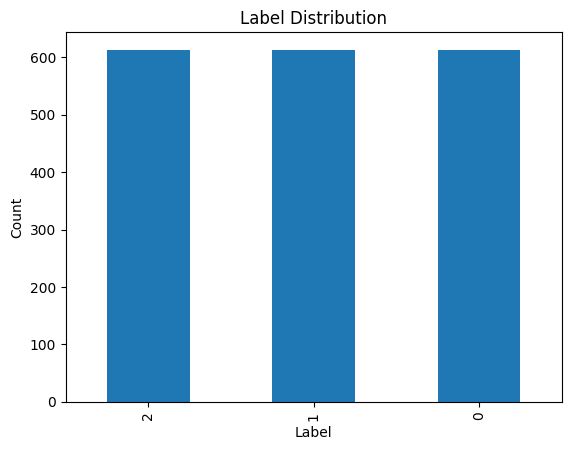

In [9]:
df_train["label"].value_counts().plot(kind="bar")
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

(-0.5, 799.5, 399.5, -0.5)

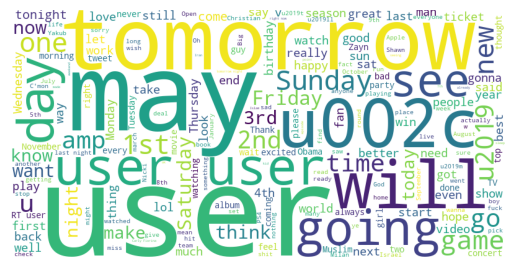

In [10]:
wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df_train["text"]))
plt.imshow(wc)
plt.axis('off')

# Data preprocessing

### Replacing most common contractions in the text with the full forms

In [11]:
contractions_dict = {
    "aren't": "are not",
    "can't": "cannot",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he's": "he is",
    "i'm": "i am",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "she's": "she is",
    "that's": "that is",
    "there's": "there is",
    "they're": "they are",
    "we're": "we are",
    "weren't": "were not",
    "what's": "what is",
    "won't": "will not",
    "wouldn't": "would not",
    "you're": "you are",
    "could've": "could have",
    "would've": "would have",
    "should've": "should have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

### Cleaning the text

In [12]:
def clean_text(text):
  #Lowercasing
  text = text.lower()
  #Removing @user
  text = re.sub(r'@\w+', '', text)
  #Removing punctuation, symbols, special characters, unicode escape sequences
  text = re.sub(r'[^\w\s]', '', text)
  #Removing numbers
  text = re.sub(r'\d+', '', text)
  #Removing extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  return text

In [13]:
df_train['cleaned'] = df_train['text'].apply(expand_contractions).apply(clean_text)

In [14]:
df_test['cleaned'] = df_test['text'].apply(expand_contractions).apply(clean_text)

In [15]:
df_val['cleaned'] = df_val['text'].apply(expand_contractions).apply(clean_text)

### TF-IDF

In [16]:
vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1,2),
    min_df=1,
    stop_words="english"
    )

X_train_vec = vectorizer.fit_transform(df_train['cleaned']).toarray()
X_test_vec = vectorizer.transform(df_test['cleaned']).toarray()
X_val_vec = vectorizer.transform(df_val['cleaned']).toarray()

(-0.5, 799.5, 399.5, -0.5)

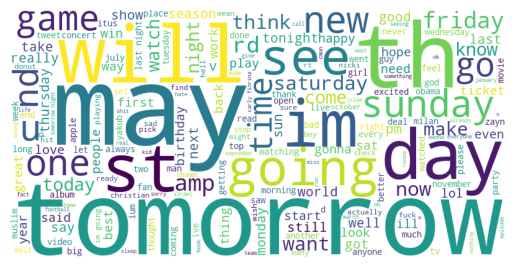

In [17]:
wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df_train["cleaned"]))
plt.imshow(wc)
plt.axis('off')

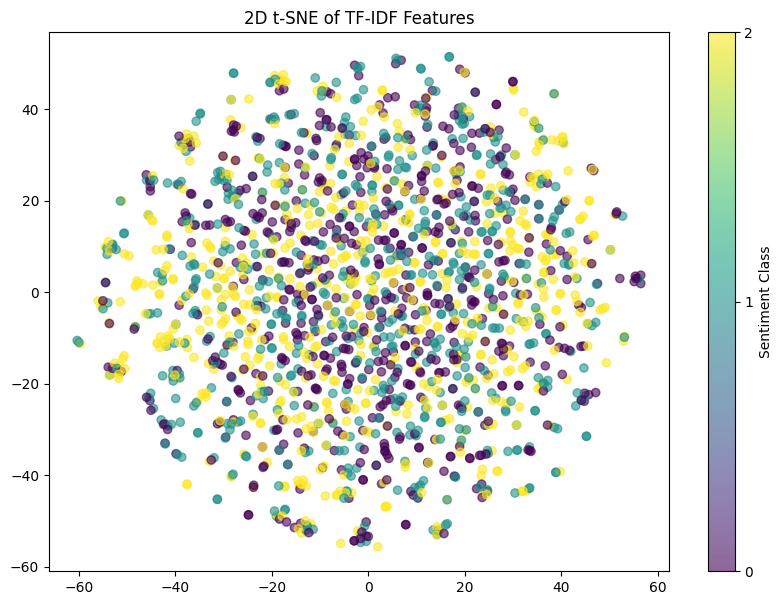

In [18]:
tsne = TSNE(n_components=2, perplexity=40, learning_rate=200)
X_train_2d = tsne.fit_transform(X_train_vec)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_train_2d[:, 0],
    X_train_2d[:, 1],
    c = df_train['label'],
    cmap="viridis",
    alpha=0.6
)

plt.colorbar(scatter, ticks=[0,1,2], label="Sentiment Class")
plt.title("2D t-SNE of TF-IDF Features")
plt.show()

### UnitTests

In [19]:
#Prompt: Create a python code for 5-10 unittest to test my data pipeline

class TestDataPipeline(unittest.TestCase):

    def test_1_expand_contractions(self):
        print("Running Test 1: Testing expand_contractions function...")
        test_text = "I'm a user, he's not. We're happy!"
        expected_text = "I am a user, he is not. We are happy!"
        self.assertEqual(expand_contractions(test_text.lower()), expected_text.lower(), "Contraction expansion failed")
        print("Test 1 Passed: expand_contractions works as expected.")

    def test_2_clean_text(self):
        print("Running Test 2: Testing clean_text function...")
        test_text = "@user This is a test! With 123 numbers and elongated characters..."
        expected_text = "this is a test with numbers and elongated characters"
        self.assertEqual(clean_text(test_text), expected_text, "Text cleaning failed")
        print("Test 2 Passed: clean_text works as expected.")

    def test_3_df_cleaned_column_exists(self):
        print("Running Test 3: Checking if 'cleaned' column exists in DataFrames...")
        self.assertIn('cleaned', df_train.columns, "'cleaned' column not found in df_train")
        self.assertIn('cleaned', df_test.columns, "'cleaned' column not found in df_test")
        self.assertIn('cleaned', df_val.columns, "'cleaned' column not found in df_val")
        print("Test 3 Passed: 'cleaned' column exists in all DataFrames.")

    def test_4_df_cleaned_content(self):
        print("Running Test 4: Checking content of 'cleaned' column for first row...")
        if not df_train.empty:
            original_text = df_train['text'].iloc[0]
            expected_cleaned = clean_text(expand_contractions(original_text))
            self.assertEqual(df_train['cleaned'].iloc[0], expected_cleaned, "Cleaned text content mismatch in df_train")
        else:
            self.fail("df_train is empty, cannot test cleaned content.")
        print("Test 4 Passed: Cleaned text content is correct for first row of df_train.")

    def test_5_tfidf_output_shape(self):
        print("Running Test 5: Checking TF-IDF vector output shapes...")
        self.assertEqual(X_train_vec.shape[0], len(df_train), "X_train_vec row count mismatch")
        self.assertEqual(X_test_vec.shape[0], len(df_test), "X_test_vec row count mismatch")
        self.assertEqual(X_val_vec.shape[0], len(df_val), "X_val_vec row count mismatch")
        self.assertEqual(X_train_vec.shape[1], 3000, "X_train_vec column count mismatch")
        self.assertEqual(X_test_vec.shape[1], 3000, "X_test_vec column count mismatch")
        self.assertEqual(X_val_vec.shape[1], 3000, "X_val_vec column count mismatch")
        print("Test 5 Passed: TF-IDF vector shapes are correct.")

    def test_6_tfidf_feature_names(self):
        print("Running Test 6: Checking TF-IDF feature names count...")
        self.assertEqual(len(vectorizer.get_feature_names_out()), 3000, "TF-IDF feature names count mismatch")
        print("Test 6 Passed: TF-IDF feature names count is correct.")

    def test_7_no_null_cleaned_text(self):
        print("Running Test 7: Checking for nulls in 'cleaned' column...")
        self.assertFalse(df_train['cleaned'].isnull().any(), "Nulls found in df_train['cleaned']")
        self.assertFalse(df_test['cleaned'].isnull().any(), "Nulls found in df_test['cleaned']")
        self.assertFalse(df_val['cleaned'].isnull().any(), "Nulls found in df_val['cleaned']")
        print("Test 7 Passed: No null values in 'cleaned' columns.")

if __name__ == '__main__':
    suite = unittest.TestSuite()
    suite.addTest(unittest.makeSuite(TestDataPipeline))
    runner = unittest.TextTestRunner(verbosity=2)
    runner.run(suite)

test_1_expand_contractions (__main__.TestDataPipeline) ... ok
test_2_clean_text (__main__.TestDataPipeline) ... ok
test_3_df_cleaned_column_exists (__main__.TestDataPipeline) ... ok
test_4_df_cleaned_content (__main__.TestDataPipeline) ... ok
test_5_tfidf_output_shape (__main__.TestDataPipeline) ... ok
test_6_tfidf_feature_names (__main__.TestDataPipeline) ... ok
test_7_no_null_cleaned_text (__main__.TestDataPipeline) ... 

Running Test 1: Testing expand_contractions function...
Test 1 Passed: expand_contractions works as expected.
Running Test 2: Testing clean_text function...
Test 2 Passed: clean_text works as expected.
Running Test 3: Checking if 'cleaned' column exists in DataFrames...
Test 3 Passed: 'cleaned' column exists in all DataFrames.
Running Test 4: Checking content of 'cleaned' column for first row...
Test 4 Passed: Cleaned text content is correct for first row of df_train.
Running Test 5: Checking TF-IDF vector output shapes...
Test 5 Passed: TF-IDF vector shapes are correct.
Running Test 6: Checking TF-IDF feature names count...
Test 6 Passed: TF-IDF feature names count is correct.
Running Test 7: Checking for nulls in 'cleaned' column...
Test 7 Passed: No null values in 'cleaned' columns.


ok

----------------------------------------------------------------------
Ran 7 tests in 0.008s

OK


# Model training

### Baseline Model — TF-IDF + Neural Network

In [20]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(3, activation='softmax', input_shape=(X_train_vec.shape[1],))
])

# Compile the model
model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Train the model
model.fit(X_train_vec, df_train['label'].values, epochs=20, batch_size=50, validation_data=(X_val_vec, df_val['label'].values))


Epoch 1/20
37/37 [==============================] - 1s 7ms/step - loss: 1.0968 - accuracy: 0.3654 - val_loss: 1.0936 - val_accuracy: 0.4259
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 1.0823 - accuracy: 0.5623 - val_loss: 1.0885 - val_accuracy: 0.4630
Epoch 3/20
37/37 [==============================] - 0s 4ms/step - loss: 1.0689 - accuracy: 0.6982 - val_loss: 1.0835 - val_accuracy: 0.5123
Epoch 4/20
37/37 [==============================] - 0s 4ms/step - loss: 1.0555 - accuracy: 0.7629 - val_loss: 1.0789 - val_accuracy: 0.5340
Epoch 5/20
37/37 [==============================] - 0s 3ms/step - loss: 1.0425 - accuracy: 0.7999 - val_loss: 1.0741 - val_accuracy: 0.5370
Epoch 6/20
37/37 [==============================] - 0s 3ms/step - loss: 1.0295 - accuracy: 0.8249 - val_loss: 1.0697 - val_accuracy: 0.5340
Epoch 7/20
37/37 [==============================] - 0s 3ms/step - loss: 1.0170 - accuracy: 0.8325 - val_loss: 1.0651 - val_accuracy: 0.5556
Epoch 8/20
37/37 [==

### Advanced Model — RoBERTa-base Fine-Tuning

In [21]:
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_fn(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized = data.map(tokenize_fn, batched=True)

In [22]:
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [23]:
from sklearn.metrics import accuracy_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

In [ ]:
report_to="none"

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

# Training arguments (Transformers v5)
training_args = TrainingArguments(
    output_dir="bert-output",
    eval_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    save_strategy="epoch",
    weight_decay=0.01,
    warmup_ratio=0.1
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.961600,0.678222,0.722222


In [25]:
model.save_pretrained("bert-output-english")

In [ ]:
save_path = "models/english"

trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

### Visualization

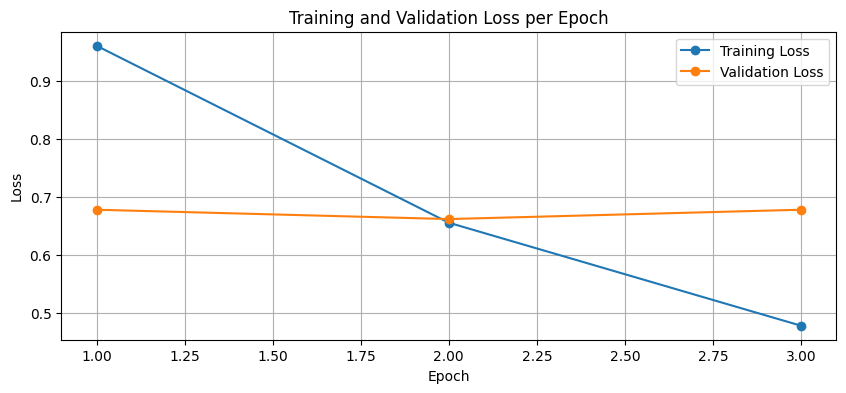

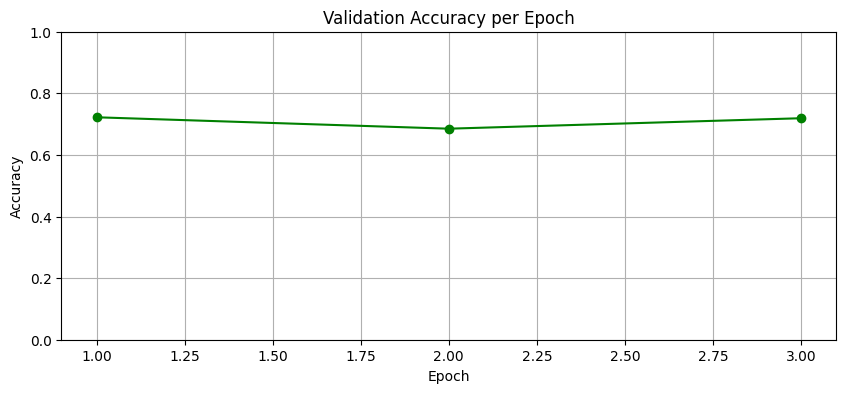

In [26]:
logs = trainer.state.log_history

epochs = []
train_loss = []
val_loss = []
val_acc = []

for log in logs:
    if "epoch" in log:
        epoch = log["epoch"]
        if epoch not in epochs:
            epochs.append(epoch)
    if "loss" in log:
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        val_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        val_acc.append(log["eval_accuracy"])

#Loss
plt.figure(figsize=(10,4))
plt.plot(range(1, int(training_args.num_train_epochs)+1), train_loss, label="Training Loss", marker='o')
plt.plot(range(1, int(training_args.num_train_epochs)+1), val_loss, label="Validation Loss", marker='o')
plt.title("Training and Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

#Accuracy
if val_acc:
    plt.figure(figsize=(10,4))
    plt.plot(range(1, int(training_args.num_train_epochs)+1), val_acc, label="Validation Accuracy", marker='o', color='green')
    plt.title("Validation Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)  # Accuracy from 0 to 100%
    plt.grid(True)
    plt.show()

### Evaluation on test data

In [27]:
test_dataset = tokenized["test"]

test_metrics = trainer.evaluate(test_dataset)
print(test_metrics)

{'eval_loss': 0.6576147079467773, 'eval_accuracy': 0.7103448275862069, 'eval_runtime': 59.8296, 'eval_samples_per_second': 14.541, 'eval_steps_per_second': 0.919, 'epoch': 3.0}


### Confusion matrix

In [ ]:
pred_output = trainer.predict(tokenized["test"])
y_pred = pred_output.predictions.argmax(axis=1)
y_true = tokenized["test"]["labels"]

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – RoBERTa-base")
plt.show()